In [15]:
! unrar x "./test.rar"

'unrar' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
! unrar x "./train.rar"

'unrar' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import cv2
import glob
from matplotlib import rcParams
import scipy.io
from tqdm import tqdm
%matplotlib inline
rcParams['figure.figsize'] = 6,6

### Loading the Dataset

In [17]:
def loadDataset(path):
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):         
        for filename in glob.glob(path + '/train/' + str(i)+'/*.png'):
            im=cv2.imread(filename, cv2.IMREAD_GRAYSCALE)             
            train_x.append(im)             
            train_y.append(i)     
    for i in range(10):         
        for filename in glob.glob(path + '/test/' + str(i)+'/*.png'):
            im=cv2.imread(filename, cv2.IMREAD_GRAYSCALE)             
            test_x.append(im)
            test_y.append(i)    
    print('Dataset loaded...')  
    return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y) 

### Methods for Data Pre-Processing

In [18]:
def TrainTest_Split(trainX, trainY):
    trainX, trainY = shuffle(trainX, trainY)
    # splitting data into train and validation
    train_idx = int(0.90 * trainX.shape[0])
    val_idx = int(0.10 * trainX.shape[0])
    trainX, validX = trainX[:train_idx], trainX[train_idx:train_idx + val_idx]
    trainY, validY = trainY[:train_idx], trainY[train_idx:train_idx + val_idx]
    return trainX, validX, trainY, validY

def One_Hot_Encode(label):
    classes = np.arange(10)
    one_hot = (classes == label).astype(np.int)
    return one_hot

def LoadFilters(path):
    data = scipy.io.loadmat(path)
    filters = data['filters'] 
    filters = np.array(filters)
    return filters

def Flatten(data):
    # reshaping data
    data = data.flatten().reshape(data.shape[0], data.shape[1]*data.shape[2]*data.shape[3])
    # taking mean of data
    mean = np.mean(data)
    # mean subtraction and normalization of data
    data -= int(mean)
    data = data/255
    return data

#### Getting Data

In [19]:
trainX,  trainY, testX, testY = loadDataset('./')
trainX.shape, testX.shape

Loading Dataset...
Dataset loaded...


((60000, 28, 28), (10000, 28, 28))

#### Splitting data into train and validation

In [20]:
trainX, validX, trainY, validY = TrainTest_Split(trainX, trainY)
trainX.shape, validX.shape

((54000, 28, 28), (6000, 28, 28))

#### One Hot Encoding of the labels

In [21]:
trainY = np.expand_dims(trainY, axis=1)
testY = np.expand_dims(testY, axis=1)
validY = np.expand_dims(validY, axis=1)
trainY = One_Hot_Encode(trainY)
testY = One_Hot_Encode(testY)
validY = One_Hot_Encode(validY)
trainY.shape, testY.shape, validY.shape

((54000, 10), (10000, 10), (6000, 10))

#### Loading the filters 

In [22]:
# Pre-Trained convolution filters 
filters = LoadFilters('filters.mat')
filters.shape

(17, 17, 36)

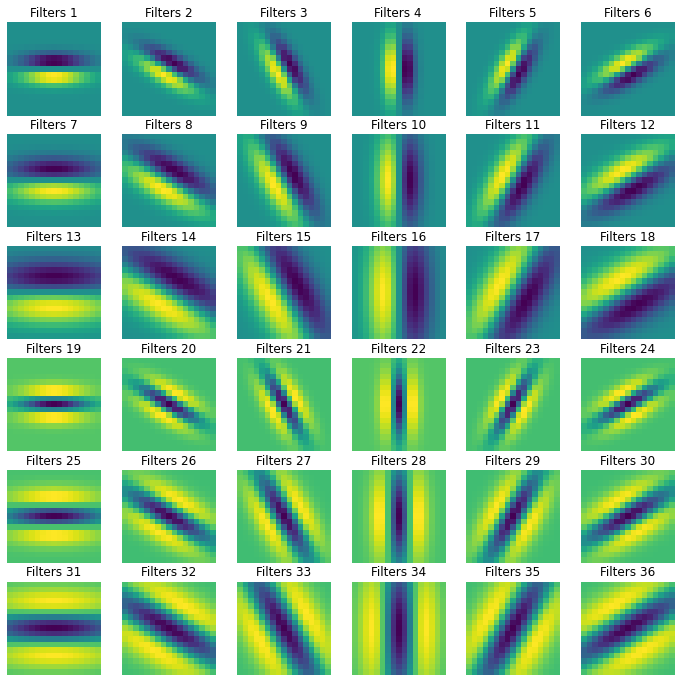

In [23]:
# Plotting filters before pooling
col=6
row=6
fig=plt.figure(figsize=(12, 12))
for i in range(1, col*row +1):
    img = filters[:,:, i-1]
    fig.add_subplot(row, col, i)
    plt.title('Filters '+str(i))
    plt.axis('off')
    plt.imshow(img)
plt.show()

### Convolution Neural Network class with functions padding, single step conv, conv forward and pooling forward

In [24]:
class Conv_Neural_Net(object):
    
    # Function to Convolve a patch of image with kernel
    def Single_Step_Conv(self, patch, kernel):
        output = np.sum(np.multiply(patch, kernel))
        return output
    
    # Function to pad the images
    def padding(self, img, pad):
        img_pad = np.pad(img, (pad,pad), 'constant', constant_values = (0,0))
        return img_pad
    
    # Activation Functions
    def relu(self, x):
        return np.where(x > 0, x, 0)
    
    # Activation Layer for non-linearity
    def Activation(self, maps, activ='relu'):
        if activ == 'relu':
            A = self.relu(maps)  
        return A
    
    # Layer. Convolution Forward function. Returns feature maps for all samples
    def Conv_forward(self, img, filters, stride=1, pad=0):
        k_row, k_col, no_of_filter = filters.shape    
        samples, nh, nw = img.shape
        nh = int(np.floor((nh - k_row + (2 * pad))/stride) + 1)
        nw = int(np.floor((nw - k_col + (2 * pad))/stride) + 1)
        outputs = np.zeros((samples, nh, nw, no_of_filter))
        img = self.padding(img, pad)
        print('Convolving samples')
        for sample in tqdm(range(samples)):
            for f in range(no_of_filter): 
                for x in range(0, nh):
                    for y in range(0, nw):
                        outputs[sample, x, y, f] = self.Single_Step_Conv(img[sample, x * stride:(x * stride) + k_row, y * stride:(y * stride) + k_col], filters[:, :, f])
        return outputs
    
    # Layer. Pooling forward function. Returns the Pooled features for all samples
    def Pool_forward(self, feature_map, mode = 'Max', filter_size=2, stride=2):
        window = np.zeros((filter_size, filter_size))
        k_row, k_col = window.shape
        samples, nh, nw, nc = feature_map.shape
        nh = int(np.floor((nh - filter_size)/stride) + 1)
        nw = int(np.floor((nw - filter_size)/stride) + 1)
        outputs = np.zeros((samples, nh, nw, nc))
        print(str(mode)+' pooling samples')
        for sample in tqdm(range(samples)):
            for f in range(nc):
                for x in range(0, nh):
                    for y in range(0, nw):
                        if mode == 'Max': outputs[sample, x, y, f] = np.max(feature_map[sample, x * stride:(x * stride) + k_row, y * stride:(y * stride) + k_col, f])
        return outputs

### Neural Network class

In [25]:
class Neural_Network(object):        
    def __init__(self, no_hidden_layers, layer_sizes):        
        # Parameter initilization
        if no_hidden_layers != len(layer_sizes)-2:
            print('There was a problem with initializing the Network. Check the parameters passed.')   
        else:
            self.model = {}
            self.no_hidden_layers = no_hidden_layers
            for l in range(no_hidden_layers + 1):
                self.model['w' + str(l+1)] = np.random.randn(layer_sizes[l], layer_sizes[l+1])
                self.model['b' + str(l+1)] = np.ones((1, layer_sizes[l+1]))
            print('Shape of Arhitecture weights is', [self.model['w' + str(each+1)].shape for each in range(no_hidden_layers+1)])

    # Activation Functions and their derivitives        
    def sigmoid(self, s):
        return 1/(1 + np.exp(-s))

    def sigmoid_derivative(self, s):
        return s * (1-s) 
    
    def softmax(self, X):
        exps = np.exp(X - np.max(X))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    # Method for getting loss
    def cross_entropy(self, Y, Y_hat):
        return -(np.sum(Y*np.log2(Y_hat+1e-12)))/len(Y)
    
    # Feed Forward method of Neural Network
    def feedforward(self, X):
        cache = {}
        cache['z1'] = X.dot(self.model['w1']) + self.model['b1']
        cache['a1'] = self.sigmoid(cache['z1'])
        if self.no_hidden_layers>1:
            for l in range(1, self.no_hidden_layers):
                cache['z'+str(l+1)] = cache['a'+str(l)].dot(self.model['w'+str(l+1)]) + self.model['b'+str(l+1)]
                cache['a'+str(l+1)] = self.sigmoid(cache['z'+str(l+1)])
        cache['z'+str(self.no_hidden_layers+1)] = cache['a'+str(self.no_hidden_layers)].dot(self.model['w'+str(self.no_hidden_layers+1)]) + self.model['b'+str(self.no_hidden_layers+1)]
        cache['a'+str(self.no_hidden_layers+1)] = self.softmax(cache['z'+str(self.no_hidden_layers+1)])
        return cache
        
    # Method for Back Propagating the weights 
    def backwardpropagate(self, X, Y, cache,  lr):
        length = X.shape[0]
        deriv = {} 
        deriv['dz'+str(self.no_hidden_layers+1)] = cache['a'+str(self.no_hidden_layers+1)] - Y
        deriv['dw'+str(self.no_hidden_layers+1)] = np.matmul(cache['a'+str(self.no_hidden_layers)].T, deriv['dz'+str(self.no_hidden_layers+1)]) / length
        deriv['db'+str(self.no_hidden_layers+1)] = np.sum(deriv['dz'+str(self.no_hidden_layers+1)], axis=0, keepdims=True) / length
        if self.no_hidden_layers>1:
            for l in range(self.no_hidden_layers, 1, -1):
                deriv['da'+str(l)] = np.matmul(deriv['dz'+str(l+1)], self.model['w'+str(l+1)].T)
                deriv['dz'+str(l)] = deriv['da'+str(l)] * self.sigmoid_derivative(cache['a'+str(l)])
                deriv['dw'+str(l)] = np.matmul(cache['a'+str(l-1)].T, deriv['dz'+str(l)]) / length
                deriv['db'+str(l)] = np.sum(deriv['dz'+str(l)], axis=0, keepdims=True) / length
        deriv['da'+str(1)] = np.matmul(deriv['dz'+str(2)], self.model['w'+str(2)].T)
        deriv['dz'+str(1)] = deriv['da'+str(1)] * self.sigmoid_derivative(cache['a'+str(1)])
        deriv['dw'+str(1)] = np.matmul(X.T, deriv['dz'+str(1)]) / length
        deriv['db'+str(1)] = np.sum(deriv['dz'+str(1)], axis=0, keepdims=True) / length
        return deriv
        
    # Updating the the weights after SGD
    def updates(self, model, deriv, lr):
        for l in range(self.no_hidden_layers+1):
            self.model['w'+str(l+1)] -= lr * deriv['dw'+str(l+1)]
            self.model['b'+str(l+1)] -= lr * deriv['db'+str(l+1)]
    
    # Stochastic Gradient Descent
    def SGD_MiniBatch(self, X, Y, learningRate , batchSize):
        for i in range(0, X.shape[0], batchSize):
            batchX = X[i : i + batchSize]
            batchy = Y[i : i + batchSize]
            cache = self.feedforward(batchX)
            deriv = self.backwardpropagate(batchX, batchy, cache, learningRate)
            self.updates(self.model, deriv, learningRate)
    
    # Method to start the training of the Neural Network
    def train(self, trainX, trainY, epochs=100, learningRate=0.1, batchSize=16 ,plot_err = True ,validationX='none', validationY='none'):
        Train_Loss = []
        Val_Loss = []
        Train_Acc = []
        Val_Acc = []
        for epoch in range(epochs):
            print('\n----------- Training for epoch',epoch,'-------------')
            self.SGD_MiniBatch(trainX, trainY, learningRate, batchSize)
            # Predict on training and Get training loss
            train_pred = self.feedforward(trainX)
            loss_train = self.cross_entropy(trainY, train_pred['a'+str(self.no_hidden_layers+1)])
            Train_Loss.append(loss_train)
            # predict on Validation and Get validation loss
            val_pred = self.feedforward(validationX)
            val_loss = self.cross_entropy(validationY, val_pred['a'+str(self.no_hidden_layers+1)])
            Val_Loss.append(val_loss)
            print("Training loss =", loss_train,"Valid loss =",val_loss)
            # Train and Validation Accuracy
            acc_train = self.meanAccuracy(trainX, trainY)
            Train_Acc.append(acc_train)
            acc_val = self.meanAccuracy(validationX, validationY)
            Val_Acc.append(acc_val)
            print("Training Accurcy =", acc_train,"Valid Accuracy =", acc_val)
        # Plotting the Loss curve and Accuray curve
        if plot_err:
            self.plot(epochs, Train_Loss, Val_Loss, Train_Acc, Val_Acc)
            
    # Method to get Predictictions on data
    def predict(self, x):
        cache = self.feedforward(x)
        return cache['a'+str(self.no_hidden_layers+1)]
    
    # Method to get Accuracy of the data
    def meanAccuracy(self, x, y):
        A = self.predict(x)
        y_hat = np.argmax(A, axis=1)
        Y = np.argmax(y, axis=1)
        accuracy = (y_hat == Y)
        accuracy = np.mean(accuracy)
        return accuracy * 100
    
    # Plotting the Error and Accuracy Curves
    def plot(self, epochs, Train_Loss, Val_Loss, Train_Acc, Val_Acc):
        plt.figure(figsize=(7,5))
        plt.plot(range(epochs), Train_Loss, label='Training Error') 
        plt.plot(range(epochs), Val_Loss, label='Validation Error') 
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.legend()
        plt.title("Training/Val Loss curve")
            
        plt.figure(figsize=(7,5))
        plt.plot(range(epochs), Train_Acc, label='Training Accuracy') 
        plt.plot(range(epochs), Val_Acc, label='Validation Accuracy') 
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy curve")
        plt.show()
    
    # Saving the weights of the model
    def savemodel(self, name):
        import pickle
        with open(name, 'wb') as handle:
            pickle.dump(self.model, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    # Loading the weights of the model
    def loadmodel(self,name):
        import pickle
        with open(name, 'rb') as handle:
            model = pickle.load(handle)
        for l in range(0, self.no_hidden_layers+1):
            self.model['w'+str(l+1)] = model['w'+str(l+1)]
            self.model['b'+str(l+1)] = model['b'+str(l+1)]

----------------

#### Instantiating CNN class and getting feature maps

In [26]:
cnn = Conv_Neural_Net()

In [28]:
feature_maps_trainX = cnn.Conv_forward(trainX, filters)
feature_maps_testX = cnn.Conv_forward(testX, filters)
feature_maps_validX = cnn.Conv_forward(validX, filters)

Convolving samples


100%|██████████| 54000/54000 [1:02:35<00:00, 14.38it/s]


Convolving samples


100%|██████████| 10000/10000 [12:03<00:00, 13.82it/s]


Convolving samples


100%|██████████| 6000/6000 [07:09<00:00, 13.96it/s]


#### Activation layer with ReLU

In [30]:
active_trainX = cnn.Activation(feature_maps_trainX)
active_testX = cnn.Activation(feature_maps_testX)
active_validX = cnn.Activation(feature_maps_validX)

#### Getting Max Pooled features

In [31]:
pooled_features_trainX = cnn.Pool_forward(active_trainX)
pooled_features_testX = cnn.Pool_forward(active_testX)
pooled_features_validX = cnn.Pool_forward(active_validX)

Max pooling samples


100%|██████████| 54000/54000 [21:57<00:00, 40.98it/s]  


Max pooling samples


100%|██████████| 10000/10000 [02:53<00:00, 57.48it/s]


Max pooling samples


100%|██████████| 6000/6000 [01:50<00:00, 54.09it/s]


#### Converting data into 1D array to pass it to FC layers

In [32]:
flattened_trainX = Flatten(pooled_features_trainX)
flattened_testX = Flatten(pooled_features_testX)
flattened_validX = Flatten(pooled_features_validX)
flattened_trainX.shape, flattened_testX.shape, flattened_validX.shape

((54000, 1296), (10000, 1296), (6000, 1296))

#### Fully Connected Network Training for classification

Shape of Arhitecture weights is [(1296, 512), (512, 128), (128, 10)]

----------- Training for epoch 0 -------------
Training loss = 0.9645885668692861 Valid loss = 0.9785168138008176
Training Accurcy = 78.92037037037038 Valid Accuracy = 78.55

----------- Training for epoch 1 -------------
Training loss = 0.7018568681140287 Valid loss = 0.7229443070054988
Training Accurcy = 85.0537037037037 Valid Accuracy = 84.65

----------- Training for epoch 2 -------------
Training loss = 0.5819645716928833 Valid loss = 0.6063524863459405
Training Accurcy = 87.86666666666667 Valid Accuracy = 87.2

----------- Training for epoch 3 -------------
Training loss = 0.5087090920063024 Valid loss = 0.5336349914349825
Training Accurcy = 89.42777777777778 Valid Accuracy = 88.5

----------- Training for epoch 4 -------------
Training loss = 0.4575193588725731 Valid loss = 0.48194103112461
Training Accurcy = 90.5425925925926 Valid Accuracy = 89.7

----------- Training for epoch 5 -------------
Training loss =

Training Accurcy = 97.13333333333334 Valid Accuracy = 96.36666666666667

----------- Training for epoch 45 -------------
Training loss = 0.1371108952547254 Valid loss = 0.1743941442449365
Training Accurcy = 97.17407407407408 Valid Accuracy = 96.38333333333333

----------- Training for epoch 46 -------------
Training loss = 0.13518219279403626 Valid loss = 0.17296977881935982
Training Accurcy = 97.2 Valid Accuracy = 96.41666666666666

----------- Training for epoch 47 -------------
Training loss = 0.1333092424789909 Valid loss = 0.1716040304698603
Training Accurcy = 97.24259259259259 Valid Accuracy = 96.43333333333334

----------- Training for epoch 48 -------------
Training loss = 0.13148918833913814 Valid loss = 0.17029399089060387
Training Accurcy = 97.28518518518518 Valid Accuracy = 96.45

----------- Training for epoch 49 -------------
Training loss = 0.1297193655639241 Valid loss = 0.16903688559119054
Training Accurcy = 97.32407407407408 Valid Accuracy = 96.45


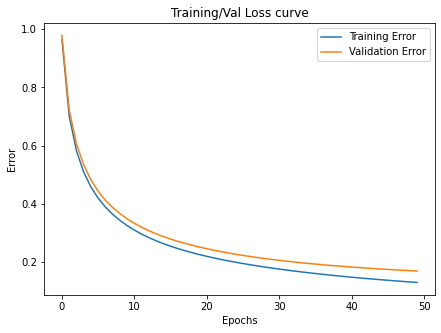

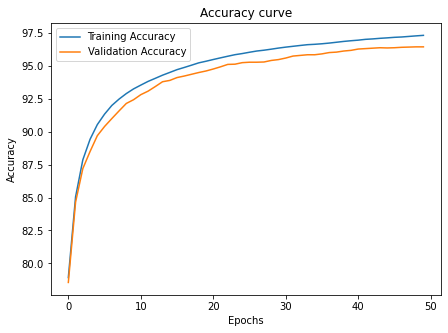

In [33]:
# Architecture with 2 hidden layer having neurons 512, 128
fcn = Neural_Network(2, [1296, 512, 128, 10])
fcn.train(flattened_trainX, trainY, epochs = 50, learningRate = 0.01, batchSize = 16 ,plot_err = True , validationX = flattened_validX, validationY = validY)
fcn.savemodel('bestmodel')    

------

#### Testing the best training parameters on Test Data

In [34]:
fcn.loadmodel('bestmodel')
print('Accuracy on Test data', fcn.meanAccuracy(flattened_testX, testY))

Accuracy on Test data 96.2


Accuracy is 96.2


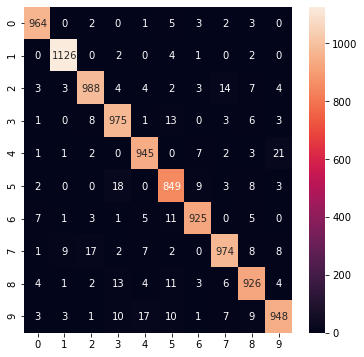

In [35]:
def matrix(testX, testY):
        # predict the value of trainX
        prediction = fcn.predict(testX)
        predict = np.argmax(prediction, axis = 1)
        groundtruth = np.argmax(testY, axis = 1)
        acc = 0
        for i in range(len(predict)):
            if(predict[i] == groundtruth[i]):
                acc = acc+1
        acc = (acc/len(predict))*100
        print('Accuracy is', acc)
        Matrix = np.zeros((10,10), dtype=np.int)
        for j in range(len(groundtruth)):
            Matrix[groundtruth[j]][predict[j]] = Matrix[groundtruth[j]][predict[j]]+1
        return Matrix
confusion_matrix = matrix(flattened_testX, testY)
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, fmt='d')

------------------

#### Plotting features before and after Pooling

In [36]:
w=10
h=10
columns = 4
rows = 5
value = np.random.randint(0, 2400)

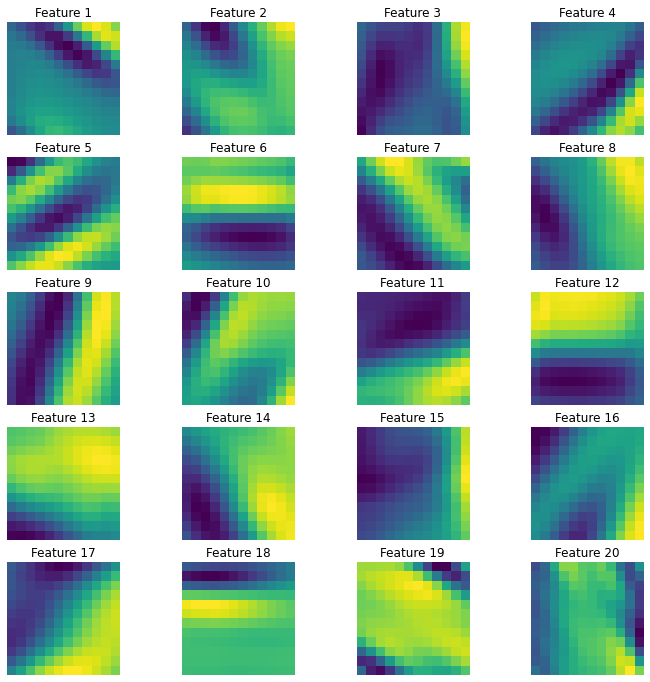

In [37]:
# Plotting features before pooling
fig=plt.figure(figsize=(12, 12))
for i in range(1, columns*rows +1):
    img = feature_maps_trainX[i*value,:,:, i]
    fig.add_subplot(rows, columns, i)
    plt.title('Feature '+str(i))
    plt.axis('off')
    plt.imshow(img)
plt.show()

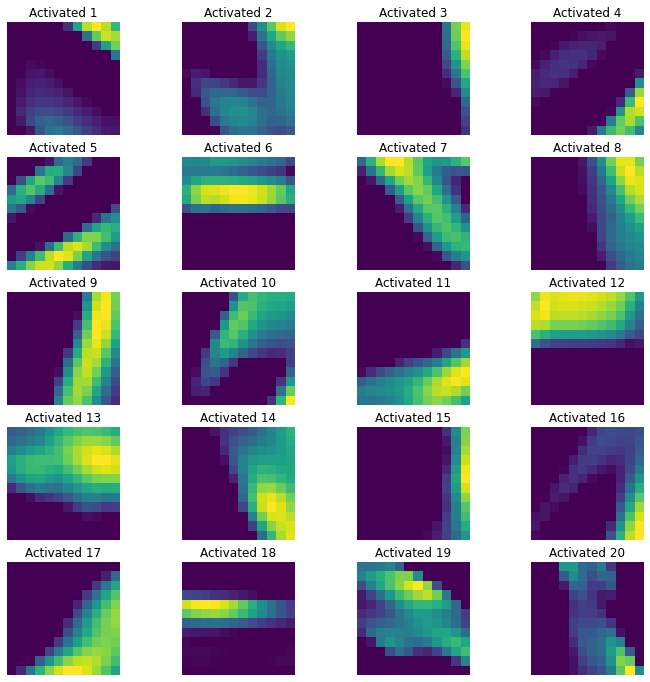

In [38]:
# Plotting features after Activation
fig=plt.figure(figsize=(12, 12))
for i in range(1, columns*rows +1):
    img = active_trainX[i*value ,:,:, i]
    fig.add_subplot(rows, columns, i)
    plt.title('Activated '+str(i))
    plt.axis('off')
    plt.imshow(img)
plt.show()

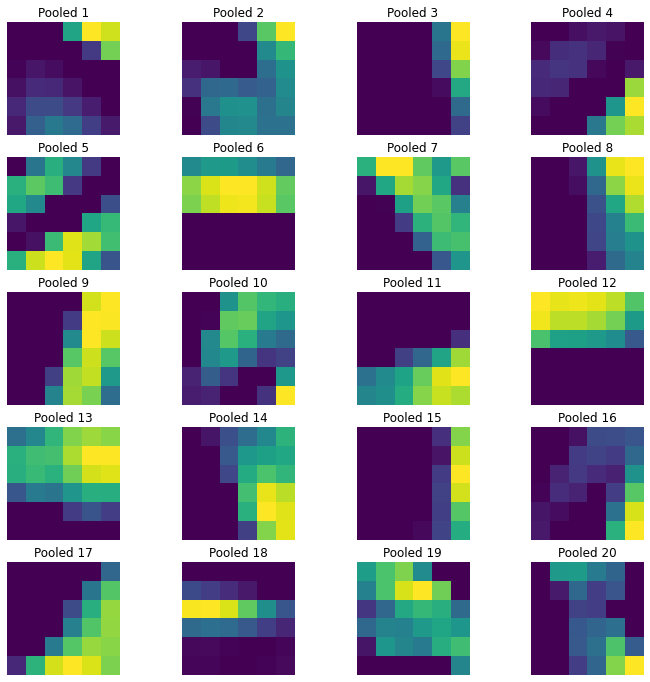

In [39]:
# Plotting features after pooling
fig=plt.figure(figsize=(12, 12))
for i in range(1, columns*rows +1):
    img = pooled_features_trainX[i*value ,:,:, i]
    fig.add_subplot(rows, columns, i)
    plt.title('Pooled '+str(i))
    plt.axis('off')
    plt.imshow(img)
plt.show()